# Wykrywanie i obliczanie działań matematycznych w postaci elektronicznej za pomocą konwolucyjnej sieci neuronowej (CNN)

In [68]:
import matplotlib.pyplot as plt                         # Tworzenie wykresów
import numpy as np                                      # Do operacji na zbiorze danych
import PIL                                              # Do otwierania obrazów w kodzie
import tensorflow as tf                                 # Główny framework machine-learningowy do tworzenia sieci neuronowych
import keras                                            # Używany jako 'interfejs' dla tensorflow
from keras import layers                                # Umożliwia budowanie sieci neuronowych poprzez dodawanie kolejnych warstw
from keras.models import Sequential                     # Umożliwia tworzenie sekwencyjnego modelu uczenia maszynowego
from keras.utils import image_dataset_from_directory    # Narzędzie do wczytywania danych w formie obrazów
import pathlib                                          # Do wczytywania danych ze ścieżki
tf.__version__

'2.15.0'

In [69]:
data_path = pathlib.Path("C:/Users/Mateusz/Desktop/data/archive/data/extracted_images") # Zmienna przechowywująca ścieżkę w której znajdują się dane
print(f"\n{data_path}")


C:\Users\Mateusz\Desktop\data\archive\data\extracted_images


In [70]:
image_count = len(list(data_path.glob('*/*.jpg'))) # Zmienna przechowywująca ilość obrazów w zbiorze danych
print(image_count)

375974


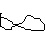

In [73]:
infinity = list(data_path.glob('infty/*')) # Przykładowy obraz ze zbioru danych
PIL.Image.open(str(infinity[0]))

# Tworzenie treningowego datasetu dzięki keras.

In [80]:
BATCH_SIZE = 32     # Ilość obrazów przetworzonych na raz podczas jednej iteracji danych
IMG_HEIGHT = 45     # Wysokość obrazu ze zbioru danych
IMG_WIDTH = 45      # Szerokość obrazu ze zbioru danych
SEED = 68           # Zmienna zachowująca ciągłość we wszystkich przypadkowych zdarzeniach, co pozwala na reprodukowalność wyników

training_dataset = image_dataset_from_directory(
    data_path,
    batch_size = BATCH_SIZE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    seed = SEED,
    color_mode='grayscale', # Obrazy zostały przekonwertowane na 'grayscale', jako że występują one jedyne w dwóch kolorach - czarny i biały
    validation_split = 0.2,
    subset = "training",
)

Found 375974 files belonging to 82 classes.
Using 300780 files for training.


# Tworzenie walidacyjnego datasetu.

In [81]:
validation_dataset = image_dataset_from_directory(
    data_path,
    batch_size=BATCH_SIZE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    seed=SEED,
    color_mode="grayscale",
    validation_split=0.2,
    subset="validation",
)

Found 375974 files belonging to 82 classes.
Using 75194 files for validation.


In [82]:
class_names = training_dataset.class_names # Zmienna przechowywująca występujące klasy obrazów. Nazywane są one po folderach w których się znajdują.
print(class_names)

['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'ascii_124', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']


# Wygenerowanie dziewięciu przykładowych obrazów z datasetu treningowego.

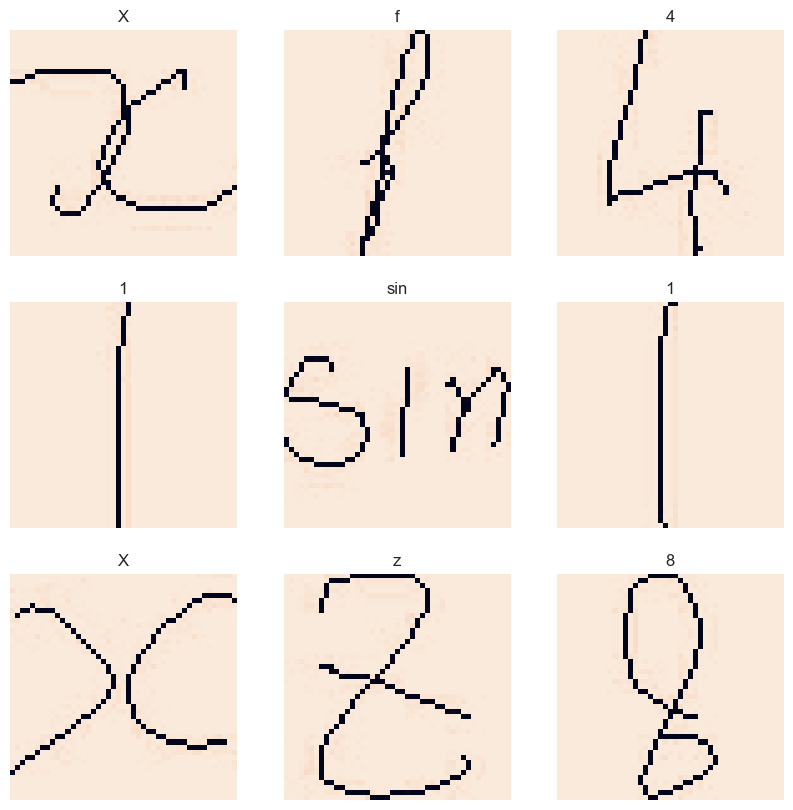

In [83]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Każdy batch posiada 32 obrazy 45x45 z jednym kanałem koloru (grayscale).

In [86]:
for image_batch, labels_batch in training_dataset: 
  print(image_batch.shape) 
  print(labels_batch.shape) 
  break
  
print("\n32 images, 45x45, grayscale")

(32, 45, 45, 1)
(32,)

32 images, 45x45, grayscale


# Tworzenie modelu

In [94]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),     # Tworzy warstwę 'normalizacji', która normalizuje wartości pikseli obrazów poprzez podzielenie ich przez 255. Dobra praktyka dla lepszej wydajności.
  layers.Conv2D(16, 3, padding='same', activation='relu'),              # Warstwa konwolucyjna, 16 neuronów z filtrami o rozmiarze 3x3, funkcja Rectified Linear Unit (wartosci ujemne zamieniane na zero)
  layers.MaxPooling2D(),                                                # Operacja poolingowa (zmnieszjająca rozmiar przestrzenny danych po wyjściu z warstwy konwolucyjnej)
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),                                                     # Warstwa spłaszczająca obrazy do 1D (ciąg pikseli). Zawsze występuje przed warstwą gęstą.
  layers.Dense(128, activation='relu'),                                 # Warstwa gęsta (fully connected layer) posiadająca 128 neuronów. Jest to warstwa wyjściowa moedlu
  layers.Dense(num_classes)                                             # Warstwa przechowywująca klasy. Klasyfikuje ona obrazy.
])

# Kompilacja modelu

In [95]:
model.compile(optimizer='adam',                                                     # Wykorzystywany jest klasyczny wielogradientowy optimizer 'Adam'.
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),    # Wybieramy funkcję straty 'SparseCategoricalCrossentropy', ponieważ jest to problem klasyfikacji wieloklasowej.
              metrics=['accuracy'])

In [96]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 45, 45, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 45, 45, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 22, 22, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 82)             │        10,578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,802 (932.82 KB)

 Trainable params: 238,802 (932.82 KB)

 Non-trainable params: 0 (0.00 B)

# Trening modelu

In [97]:
epochs=10
history = model.fit(training_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/10
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - accuracy: 0.8158 - loss: 0.7265 - val_accuracy: 0.9404 - val_loss: 0.1977
Epoch 2/10
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - accuracy: 0.9471 - loss: 0.1721 - val_accuracy: 0.9543 - val_loss: 0.1454
Epoch 3/10
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 86s 9ms/step - accuracy: 0.9636 - loss: 0.1148 - val_accuracy: 0.9647 - val_loss: 0.1099
Epoch 4/10
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.9714 - loss: 0.0874 - val_accuracy: 0.9694 - val_loss: 0.0961
Epoch 5/10
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9760 - loss: 0.0726 - val_accuracy: 0.9743 - val_loss: 0.0780
Epoch 6/10
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.9799 - loss: 0.0612 - val_accuracy: 0.9758 - val_loss: 0.0755
Epoch 7/10
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.9823 - loss: 0.0541 - val_accuracy: 0.9806 - val_loss: 0.0615
Epoch 8/10
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.9838 - loss: 0

# Grafiki przedstawiające wydajność treningową modelu. Jest zadowalająca, ale mogłaby być lepsza. Zauważyć możemy, że strata na danych walidacyjnych znacznie przewyższa stratę na danych treningowych, szczególnie na samym końcu.

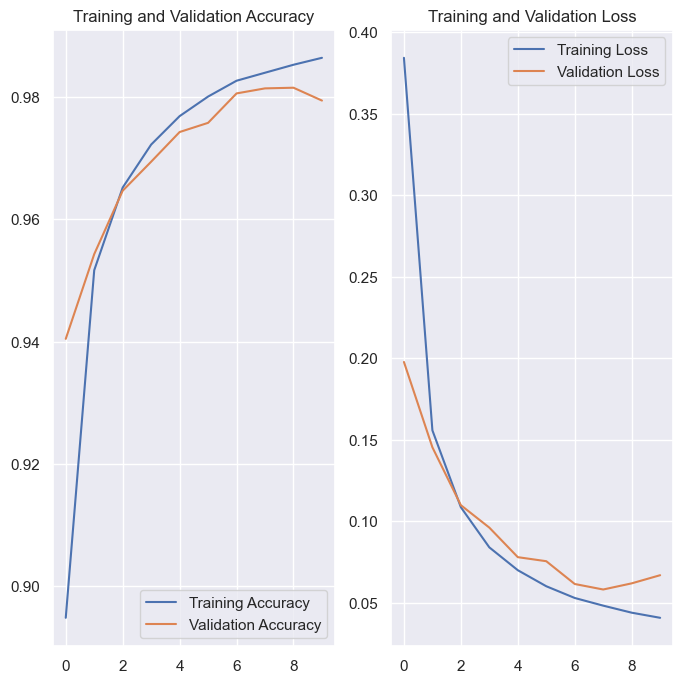

In [98]:
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Sprawdzenie modelu. Niestety wykonał on niepoprawne typowanie klasy dla danego obrazu.

In [111]:
img = PIL.Image.open('examples/sqrt2.png').convert('L')
img = img.resize((IMG_WIDTH, IMG_HEIGHT))
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
This image most likely belongs to i with a 29.33 percent confidence.


# Dla usprawnienia uczenia maszynowego wykonujemy lekkie zmiany w naszym datasecie. Każdy obrazek z danej kategorii zostaje delikatnie obrócony.

In [112]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

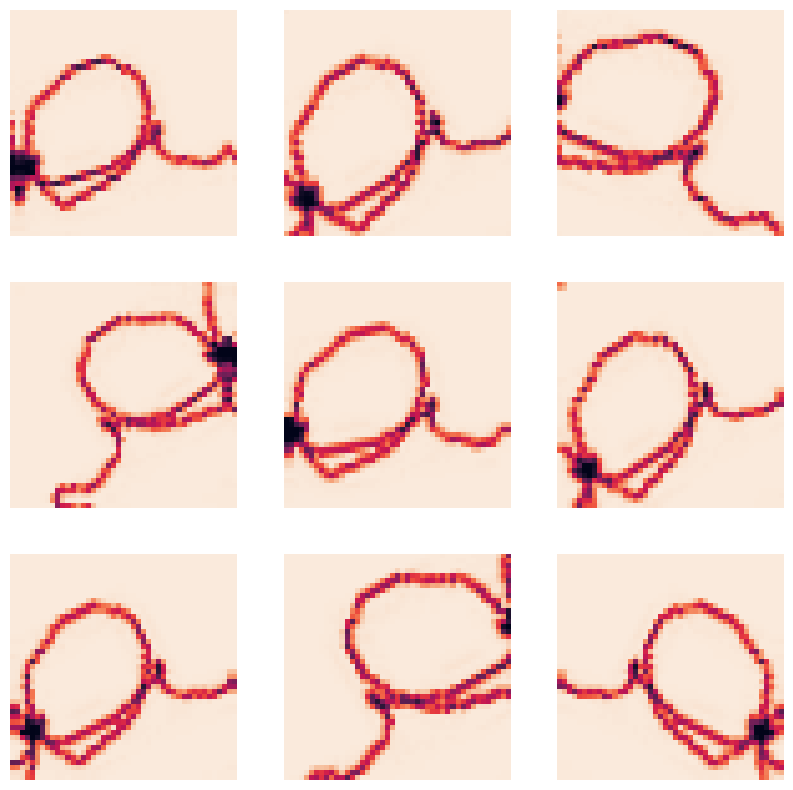

In [113]:
plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [118]:
model = Sequential([
  data_augmentation,                                                 # Tym razem dodajemy warstwę 'data_augmentation', aby dodać danym różnorodności.
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),                                               # Dodajemy również warstwę 'dropout' aby zmniejszyć ryzyko przeuczenia modelu.
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [119]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [121]:
epochs = 15
history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/15
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 105s 11ms/step - accuracy: 0.5810 - loss: 1.5695 - val_accuracy: 0.8080 - val_loss: 0.6319
Epoch 2/15
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 102s 11ms/step - accuracy: 0.8034 - loss: 0.6542 - val_accuracy: 0.8544 - val_loss: 0.4628
Epoch 3/15
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 102s 11ms/step - accuracy: 0.8328 - loss: 0.5430 - val_accuracy: 0.8546 - val_loss: 0.4625
Epoch 4/15
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 104s 11ms/step - accuracy: 0.8460 - loss: 0.4947 - val_accuracy: 0.8694 - val_loss: 0.4134
Epoch 5/15
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 103s 11ms/step - accuracy: 0.8546 - loss: 0.4596 - val_accuracy: 0.8803 - val_loss: 0.3646
Epoch 6/15
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 102s 11ms/step - accuracy: 0.8620 - loss: 0.4373 - val_accuracy: 0.8853 - val_loss: 0.3603
Epoch 7/15
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 105s 11ms/step - accuracy: 0.8652 - loss: 0.4221 - val_accuracy: 0.8842 - val_loss: 0.3628
Epoch 8/15
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 104s 11ms/step - accuracy: 

# Strata danych walidacyjnych w tym wypadku wygląda znacznie lepiej.

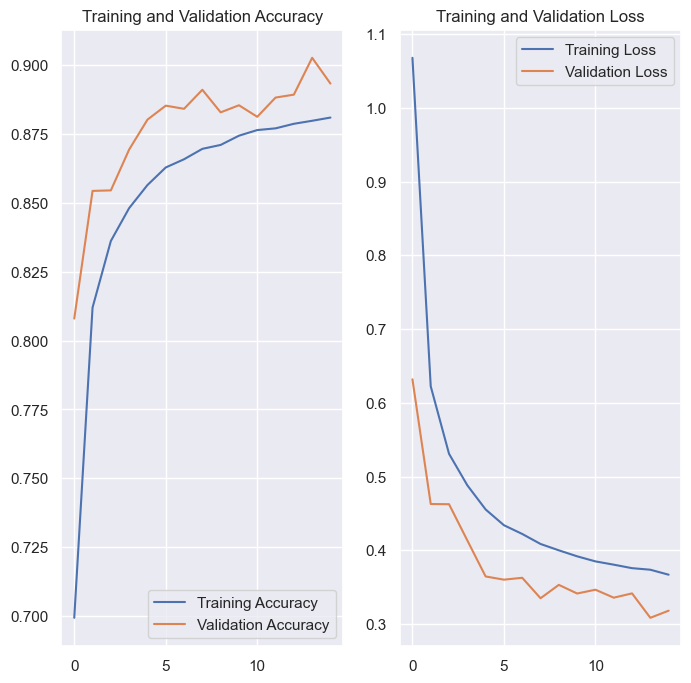

In [122]:
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model poprawnie rozpoznał liczbę.

In [130]:
img = PIL.Image.open('examples/seven.png').convert('L') 
img = img.resize((IMG_WIDTH, IMG_HEIGHT))
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
This image most likely belongs to 7 with a 96.81 percent confidence.


In [131]:
predictions_x = model.predict(validation_dataset)

2350/2350 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step


# Na koniec tworzymy tzw. macierz konfuzji aby ocenić poprawność działania modelu.

In [148]:
true_labels = []
predicted_labels = []

for images, labels in validation_dataset:
    predictions = model.predict(images)
    predicted_indices = np.argmax(predictions, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_indices)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
confusion_matrix = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels, num_classes=num_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [151]:
confusion_matrix

<tf.Tensor: shape=(82, 82), dtype=int32, numpy=
array([[ 244,    0,    0, ...,    0,    0,    0],
       [   0, 2450,  288, ...,    0,    0,    2],
       [   0, 1045, 1634, ...,    0,    0,    2],
       ...,
       [   0,    0,    0, ...,  941,    0,    0],
       [   0,    0,    1, ...,    0,   52,    9],
       [   0,    0,    2, ...,    0,   12,   45]])>

# Jak widać na obrazku widzimy wyraźną linię po środku. Jest to znak, że model działa zadolwająco.

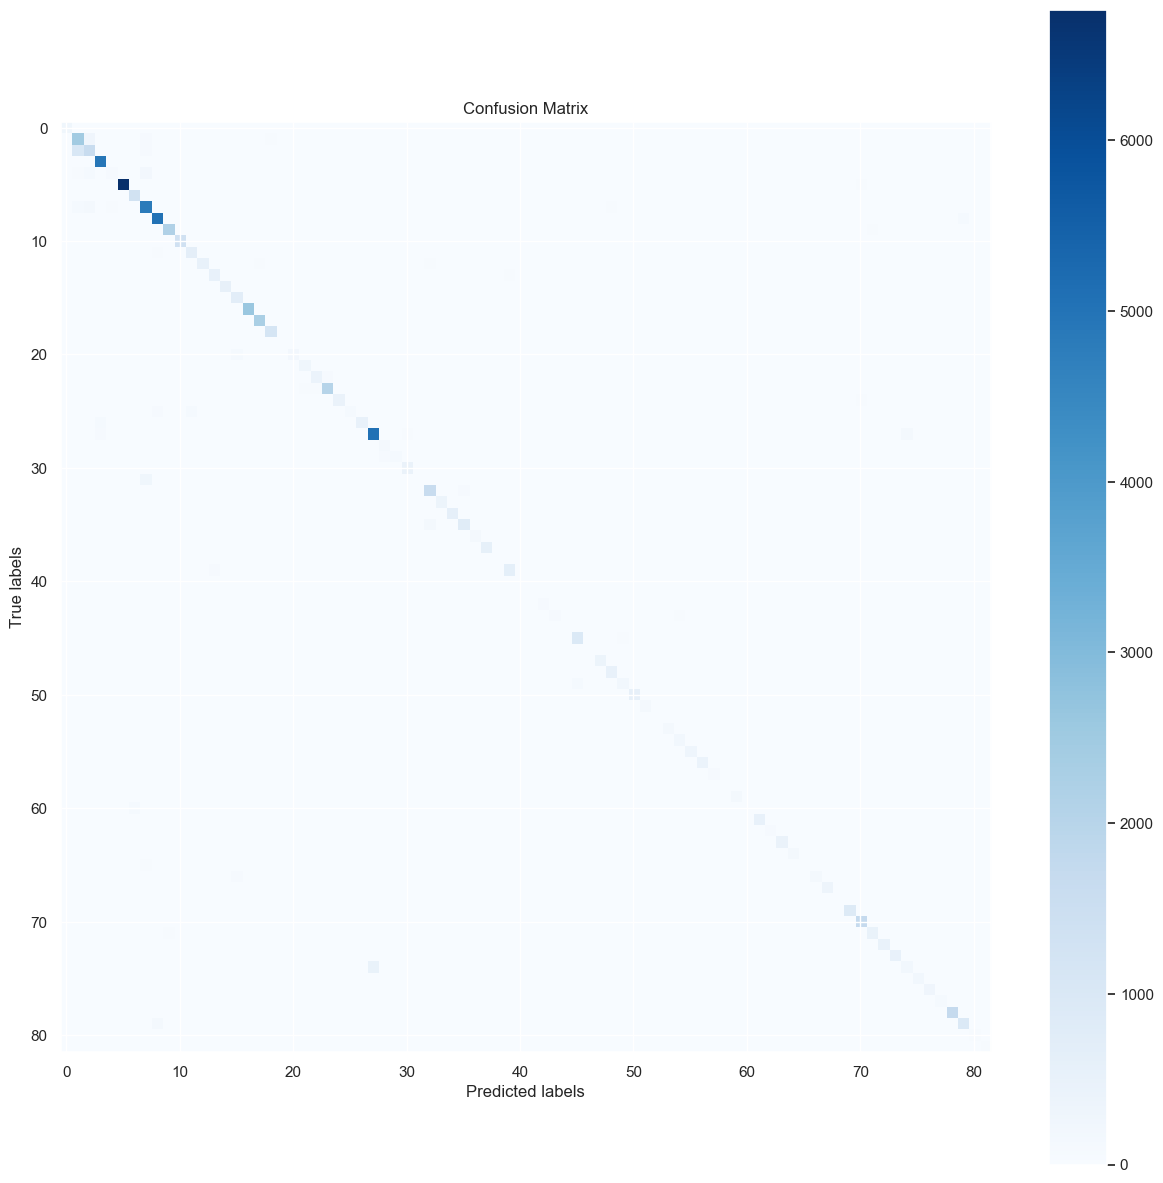

In [155]:
plt.figure(figsize=(15, 15))
plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

# Działający model zapisujemy do pliku.

In [159]:
model.save('equation_solver.keras')